## Support Vector Machines SVM

In [298]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

### About data

**Описание задачи и постановка цели.**  
Дистрибьюторская компания, специализирующаяся на экспорте вин премиального качества, столкнулась с проблемой фальсификации продукции. В связи с этим был инициирован химический анализ широкого спектра для выявления подделок. Был зафиксирован случай, когда один из поставщиков попытался сбыть вино более низкого качества, выдавая его за более дорогой сорт.

В связи с этим возникла необходимость в разработке алгоритма машинного обучения, который мог бы, основываясь на результатах ряда химических тестов, определять подлинность вина и отличать его от поддельного продукта. Целью этого проекта является создание предиктивной модели, способной с высокой точностью классифицировать вино как настоящее или контрафактное.

In [275]:
df = pd.read_csv("D:/Machine Learning/Новая папка/_DATA/wine_fraud.csv")

In [276]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Legit,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,Legit,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,Legit,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,Legit,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Legit,red


### Exploratory Data Analysis (EDA)

Целевая переменная.

In [277]:
df['quality'].unique()

array(['Legit', 'Fraud'], dtype=object)

Наблюдается очень высокий уровень дисбаланса. Соотношение классов "Legit" к "Fraud" составляет примерно 25 к 1 (6251 / 246 ≈ 25.4)

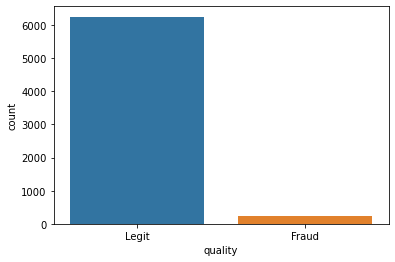

In [279]:
sns.countplot(data =df, x ='quality');

Определим степень различия в количестве подделок в зависимости от категории вина ('red' или 'white')

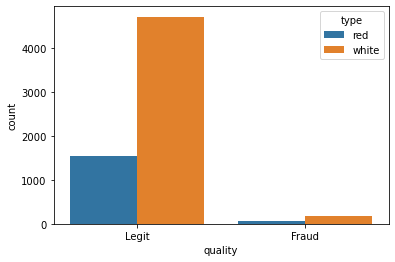

In [280]:
sns.countplot(data =df, x ='quality', hue = 'type');

In [281]:
df.groupby(['type', 'quality']).agg(cnt=('type', 'count'))

cnt
type  quality      
red   Fraud      63
      Legit    1536
white Fraud     183
      Legit    4715

Процент подделок для красного вина ≈ 3.94%   
Процент подделок для красного вина ≈ 3.74%   

In [282]:
df['Fraud']= df['quality'].map({'Legit':0,'Fraud':1})

In [283]:
df_corr = df.corr()['Fraud'].sort_values()
df_corr[:-1]

free sulfur dioxide    -0.085204
citric acid            -0.061789
alcohol                -0.051141
residual sugar         -0.048756
total sulfur dioxide   -0.035252
sulphates              -0.034046
density                 0.016351
pH                      0.020107
fixed acidity           0.021794
chlorides               0.034499
volatile acidity        0.151228
Name: Fraud, dtype: float64

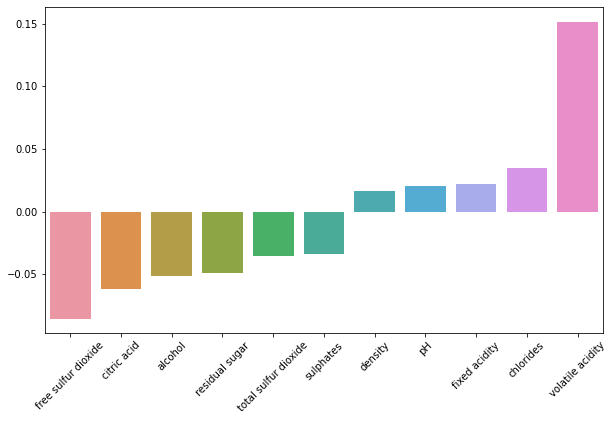

In [284]:
coefs = pd.Series(df_corr.drop('Fraud'))
coefs = coefs.sort_values()
plt.figure(figsize=(10,6))
sns.barplot(x=coefs.index,y=coefs.values)
plt.xticks(rotation=45);

Визуализация матрицы корреляции признаков с помощью тепловой карты

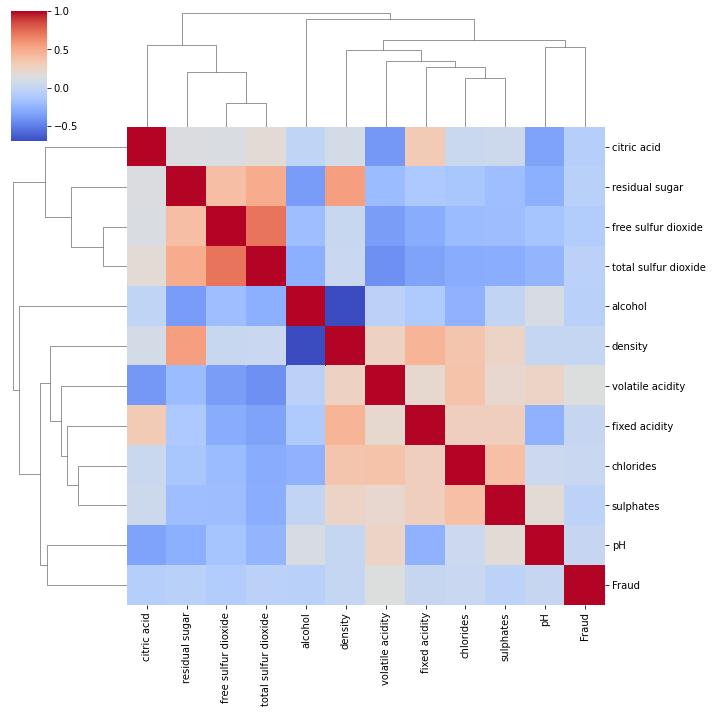

In [285]:
sns.clustermap(df.corr(),cmap='coolwarm');

### Feature Engineering (one-hot encoding)

In [286]:
df['quality'] = df['quality'].map({'Legit': 1, 'Fraud': 0})

In [287]:
df = df.drop('Fraud',axis=1)
df['type'] = pd.get_dummies(df['type'],drop_first=True)
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,1,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,1,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,1,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,1,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,1,1
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,1,1
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,1,1
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,1,1


### Data Splitting

In [288]:
X = df.drop('quality',axis=1)
y = df['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=101)

### Data Scaling

In [289]:
scaler = StandardScaler()

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

### Model Initialization

In [290]:
svm = SVC(class_weight='balanced')

In [291]:
param_grid = {'C': [0.001, 0.01, 0.1, 0.5, 1],
            'gamma': ['scale', 'auto']}

grid = GridSearchCV(svm,param_grid)

In [292]:
grid.fit(scaled_X_train,y_train)

GridSearchCV(estimator=SVC(class_weight='balanced'),
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1],
                         'gamma': ['scale', 'auto']})

In [293]:
grid.best_params_

{'C': 1, 'gamma': 'auto'}

### Prediction and Evaluation

- Confusion Matrix Array  
- Classification Report  

In [294]:
y_pred = grid.predict(scaled_X_test)

In [295]:
confusion_matrix(y_test,y_pred)

array([[ 17,  10],
       [ 92, 531]], dtype=int64)

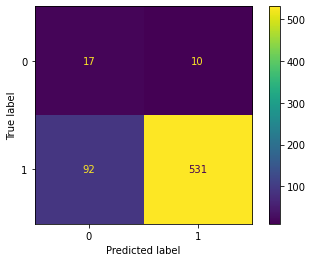

In [299]:
cm = confusion_matrix(y_test, y_pred, labels=grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid.classes_)
disp.plot()
plt.show()

In [296]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.16      0.63      0.25        27
           1       0.98      0.85      0.91       623

    accuracy                           0.84       650
   macro avg       0.57      0.74      0.58       650
weighted avg       0.95      0.84      0.88       650



Анализ результатов моделирования показал, что точность классификации вин как поддельных является недостаточной. Основной причиной данной проблемы, вероятно, является ограниченность используемых данных. Химический состав вина, доступный для анализа, может быть недостаточным для однозначного определения его подлинности.

Для повышения качества классификации и улучшения прогностической способности модели рекомендуется расширить набор данных за счет дополнительных признаков, таких как:

- характеристики упаковки и этикетки;

- сведения о месте и условиях приобретения;

- любые другие данные, которые могут иметь отношение к происхождению и аутентичности вина.

Применение расширенного набора признаков позволит более эффективно выявлять поддельные образцы и повысить общую надежность классификационной модели.